In [1]:
import utils, json, requests as req, pandas as pd
import matplotlib.pyplot as plt, numpy as np, random
import xml.etree.ElementTree as ET
from utils import *

# Get Data

In [2]:
# GO Term - Protein
go_term_cell_comp2protein = json.load(open('data/go_term_cell_comp2protein.json')) ####make go_term_to_protein

# Mitochondrial Proteins
mitochondrial_proteins = go_term_cell_comp2protein['mitochondrion']
human_protein_ids = get_human_proteins()
human_mitochondrial_proteins = human_protein_ids.intersection(mitochondrial_proteins)

# Protein ID -[is]- Protein Name
protein_name_to_id, protein_id_to_name = get_protein_name_to_ids()

# Gene Name -[is]- Protein ID
gene_name_to_protein_id, protein_id_to_gene_name = map_protein_ids_to_gene_names()

### Drug-Proteins

In [3]:
# Drug -[rel]- proteins
drug_to_protein_dicts = json.load(open('data/drug_to_protein_dicts.json'))

# Drug -[rel]- mitochondrial proteins
drug_to_mitochondrial_targets = map_drug_to_go_term_proteins('target', drug_to_protein_dicts, human_mitochondrial_proteins, 'mitochondrial')
drug_to_mitochondrial_enzymes = map_drug_to_go_term_proteins('enzyme', drug_to_protein_dicts, human_mitochondrial_proteins, 'mitochondrial')
drug_to_mitochondrial_carriers = map_drug_to_go_term_proteins('carrier', drug_to_protein_dicts, human_mitochondrial_proteins, 'mitochondrial')
drug_to_mitochondrial_transporters = map_drug_to_go_term_proteins('transporter', drug_to_protein_dicts, human_mitochondrial_proteins, 'mitochondrial')

# Drug -[rel]- proportion mitochondrial proteins
drug_to_proportion_mitochondrial_targets = get_drugs_proportion_go_proteins(drug_to_protein_dicts['target'], drug_to_mitochondrial_targets)
drug_to_proportion_mitochondrial_carriers = get_drugs_proportion_go_proteins(drug_to_protein_dicts['carrier'], drug_to_mitochondrial_carriers)
drug_to_proportion_mitochondrial_enzymes = get_drugs_proportion_go_proteins(drug_to_protein_dicts['enzyme'], drug_to_mitochondrial_enzymes)
drug_to_proportion_mitochondrial_transporters = get_drugs_proportion_go_proteins(drug_to_protein_dicts['transporter'], drug_to_mitochondrial_transporters)

### Protein-[associated with]-Disease

#### DisGeNET

In [136]:
''' Diseases '''
# MeSH -[is]- UMLS (NOTE: Make code for this VVV)
kgdr_path = '../Drug Repurposing Knowledge Graph/'
umls_to_mesh_id = json.load(open(kgdr_path+'output/otherMappings/umls2mesh_all.json'))

# MeSH Name -[is]- MeSH ID -[is]- MeSH Tree Number
tree = ET.parse('data/desc2022.xml')
root = tree.getroot()
mesh_name_to_id, mesh_id_to_name, mesh_tree_to_id, mesh_id_to_tree, all_tree_numbers = get_mesh_name_id_tree_mappings(root)

# MeSH Tree Number -[child of]- MeSH Tree Number
tree_to_tree = get_mesh_tree_hierarchy(all_tree_numbers)

# Gene-Disease Association Dataframe
gda_df = get_gene_disease_association_df()
threshold = 0.2 # arbitrary
filtered_gda_df = gda_df[gda_df['score']>= threshold]
# Get studied UMLS IDs that are cardiovascular diseases
cardiovascular_disease = 'C14'
umls_cardiovascular_diseases = get_umls_mesh_category(cardiovascular_disease, list(filtered_gda_df['diseaseId']), umls_to_mesh_id, mesh_id_to_tree)
gda_cvd_df = filtered_gda_df.query('diseaseId in @umls_cardiovascular_diseases')

# Disease Name -[is]- Disease ID
disease_id_to_name, disease_name_to_id = get_disease_id_to_name(gda_cvd_df)
print(len(set(gda_cvd_df['diseaseId'])), 'diseases')

456 diseases


In [6]:
''' Protein - Diseases (CVDs)'''
# Protein/Gene -[associated with]- Diseases
protein_to_cvd, cvd_to_protein, gene_to_cvd, cvd_to_gene = get_protein_disease_associations(gda_cvd_df)

# Protein -[associated with]- CVDs
cvds_to_mito_protein, mito_protein_to_cvd, mito_protein_name_to_cvd_name, cvd_name_to_mito_protein_name = get_disease_to_protein_dicts(cvd_to_protein, human_mitochondrial_proteins, disease_id_to_name, protein_id_to_name)
cvds_to_protein, protein_to_cvd, protein_name_to_cvd_name, cvd_name_to_protein_name = get_disease_to_protein_dicts(cvd_to_protein, human_protein_ids, disease_id_to_name, protein_id_to_name)

# Top Mitochondrial Proteins and CVDs   
cvds_with_most_mito_proteins_names = sort_dict_by_values_length(cvd_name_to_mito_protein_name)
cvds_with_most_mito_proteins = sort_dict_by_values_length(cvds_to_mito_protein)
mito_proteins_with_most_cvd_names = sort_dict_by_values_length(mito_protein_name_to_cvd_name)
mito_proteins_with_most_cvd = sort_dict_by_values_length(mito_protein_to_cvd)

### Drug-Disease

In [118]:
# Actual Drug-Disease
mesh_to_umls = json.load(open(kgdr_path+'output/otherMappings/mesh2umls_all.json'))
db_to_mesh_df = pd.read_csv('../Drug Repurposing Knowledge Graph/output/compound2disease/edges_drugbankCompound-TREATS->meshDisease.csv')
drug_treats_disease, disease_treated_drug, treated_cardiovascular_diseases = get_drug_treats_disease(db_to_mesh_df, mesh_to_umls, umls_cardiovascular_diseases)
cvd_treated_by_drugs, drug_treats_cvds = get_drug_treats_your_disease(drug_treats_disease, treated_cardiovascular_diseases)

# Predicted Drug-Disease
result_table_dir = 'PathFX/results/all_network_results/'
predicted_drug_to_disease = get_drugs_predicted_phenotypes(result_table_dir, bh_cutoff = 0.05)

# Correctly Predicted Drug-Disease
correct_drug_to_disease = get_correctly_predicted_drug_to_disease(predicted_drug_to_disease, drug_treats_disease)
correct_drug_to_cvd = get_correctly_predicted_drug_to_disease(predicted_drug_to_disease, drug_treats_cvds)

In [142]:
print(len(predicted_drug_to_disease),'predicted drugs to diseases')
print(len(correct_drug_to_disease),'correctly-predicted drugs to diseases')

#print(len(predicted_drug_to_cvd),'predicted CVDs')
print(len(drug_treats_cvds),'drugs that treat CVDs')
print(len(correct_drug_to_cvd),'correctly-predicted drugs to CVDs')

3642 predicted drugs to diseases
1256 correctly-predicted drugs to diseases
974 drugs that treat CVDs
546 correctly-predicted drugs to CVDs


### Drug-Protein-Disease Pathways

In [129]:
drug_to_disease_to_genes, drug_to_disease_to_proteins = get_pathways_genes_and_proteins(correct_drug_to_disease, bh_cutoff = 0.05)
drug_to_cvd_to_genes, drug_to_cvd_to_proteins = get_pathways_genes_and_proteins(correct_drug_to_cvd, bh_cutoff = 0.05)

# Analyze Data
- Check proportion of mitochondrial proteins in targets, disease-proteins, and pathway
- Compare those proportions

###### Mitochondrial Proteins / All Proteins

In [130]:
print(f'{len(human_mitochondrial_proteins)} mitochondrial proteins')
print(f'{len(human_protein_ids)} total human proteins')
print(f'{round(len(human_mitochondrial_proteins)/len(human_protein_ids),4)*100}%')

1354 mitochondrial proteins
20386 total human proteins
6.64%


##### Mitochondrial Drug-Related Proteins / All Drug-Related Proteins

In [150]:
protein_interacting_drugs = list()
for rel in drug_to_protein_dicts:
    print(f'{len(drug_to_protein_dicts[rel])} {rel}s')
    protein_interacting_drugs += drug_to_protein_dicts[rel]
protein_interacting_drugs = set(protein_interacting_drugs)
print(len(protein_interacting_drugs),'total proteins')

5804 targets
612 carriers
1737 enzymes
1050 transporters
6389 total proteins


In [82]:
'''All Drugs'''
print('ACTUAL')
unique_all_targets, all_targets = get_all_drugs_proteins(drug_to_protein_dicts['target'])
unique_mitochondrial_targets, mitochondrial_targets = get_mitochondrial_drugs_proteins(all_targets, human_mitochondrial_proteins)
display_go_related_proportions(unique_all_targets, all_targets, 
                               unique_mitochondrial_targets, mitochondrial_targets,
                               rel = 'targets', go_term = 'mitochondrial', drug_type = 'drug')

unique_all_enzymes, all_enzymes = get_all_drugs_proteins(drug_to_protein_dicts['enzyme'])
unique_mitochondrial_enzymes, mitochondrial_enzymes = get_mitochondrial_drugs_proteins(all_enzymes, human_mitochondrial_proteins)
display_go_related_proportions(unique_all_enzymes, all_enzymes, 
                               unique_mitochondrial_enzymes, mitochondrial_enzymes,
                               rel = 'enzymes', go_term = 'mitochondrial', drug_type = 'drug')

unique_all_carriers, all_carriers = get_all_drugs_proteins(drug_to_protein_dicts['carrier'])
unique_mitochondrial_carriers, mitochondrial_carriers = get_mitochondrial_drugs_proteins(all_carriers, human_mitochondrial_proteins)
display_go_related_proportions(unique_all_carriers, all_carriers, 
                               unique_mitochondrial_carriers, mitochondrial_carriers,
                               rel = 'carriers', go_term = 'mitochondrial', drug_type = 'drug')

unique_all_transporters, all_transporters = get_all_drugs_proteins(drug_to_protein_dicts['transporter'])
unique_mitochondrial_transporters, mitochondrial_transporters = get_mitochondrial_drugs_proteins(all_transporters, human_mitochondrial_proteins)
display_go_related_proportions(unique_all_transporters, all_transporters, 
                               unique_mitochondrial_transporters, mitochondrial_transporters,
                               rel = 'transporters', go_term = 'mitochondrial', drug_type = 'drug')


'''CVD Drugs'''
unique_cvd_targets, cvd_targets = get_your_diseases_drugs_proteins(drug_treats_cvds, drug_to_protein_dicts['target'])
unique_mitochondrial_cvd_targets, mitochondrial_cvd_targets = get_mitochondrial_drugs_proteins(cvd_targets, human_mitochondrial_proteins)
display_go_related_proportions(unique_cvd_targets, cvd_targets, 
                               unique_mitochondrial_cvd_targets, mitochondrial_cvd_targets,
                               rel = 'targets', go_term = 'mitochondrial', drug_type = 'CVD drug')

unique_cvd_enzymes, cvd_enzymes = get_your_diseases_drugs_proteins(drug_treats_cvds, drug_to_protein_dicts['enzyme'])
unique_mitochondrial_cvd_enzymes, mitochondrial_cvd_enzymes = get_mitochondrial_drugs_proteins(cvd_enzymes, human_mitochondrial_proteins)
display_go_related_proportions(unique_cvd_enzymes, cvd_enzymes, 
                               unique_mitochondrial_cvd_enzymes, mitochondrial_cvd_enzymes,
                               rel = 'enzymes', go_term = 'mitochondrial', drug_type = 'CVD drug')

unique_cvd_transporters, cvd_transporters = get_your_diseases_drugs_proteins(drug_treats_cvds, drug_to_protein_dicts['transporter'])
unique_mitochondrial_cvd_transporters, mitochondrial_cvd_transporters = get_mitochondrial_drugs_proteins(cvd_transporters, human_mitochondrial_proteins)
display_go_related_proportions(unique_cvd_transporters, cvd_transporters, 
                               unique_mitochondrial_cvd_transporters, mitochondrial_cvd_transporters,
                               rel = 'transporters', go_term = 'mitochondrial', drug_type = 'CVD drug')

unique_cvd_carriers, cvd_carriers = get_your_diseases_drugs_proteins(drug_treats_cvds, drug_to_protein_dicts['carrier'])
unique_mitochondrial_cvd_carriers, mitochondrial_cvd_carriers = get_mitochondrial_drugs_proteins(cvd_carriers, human_mitochondrial_proteins)
display_go_related_proportions(unique_cvd_carriers, cvd_carriers, 
                               unique_mitochondrial_cvd_carriers, mitochondrial_cvd_carriers,
                               rel = 'carriers', go_term = 'mitochondrial', drug_type = 'CVD drug')

ACTUAL
2801 unique targets of 14335 targets 
1657 mitochondrial drug targets of all 14335 drug targets (11.600000000000001%))
402 unique mitochondrial drug targets of all 2801 unique drug targets (14.399999999999999%))

393 unique enzymes of 5334 enzymes 
710 mitochondrial drug enzymes of all 5334 drug enzymes (13.3%))
72 unique mitochondrial drug enzymes of all 393 unique drug enzymes (18.3%))

75 unique carriers of 866 carriers 
0 mitochondrial drug carriers of all 866 drug carriers (0.0%))
0 unique mitochondrial drug carriers of all 75 unique drug carriers (0.0%))

258 unique transporters of 3214 transporters 
66 mitochondrial drug transporters of all 3214 drug transporters (2.1%))
18 unique mitochondrial drug transporters of all 258 unique drug transporters (7.000000000000001%))

1163 unique targets of 3242 targets 
281 mitochondrial CVD drug targets of all 3242 CVD drug targets (8.7%))
159 unique mitochondrial CVD drug targets of all 1163 unique CVD drug targets (13.70000000000000

(0.0, 0.0)

In [79]:
'''
PERMUTATION TEST
'''
print('Permutation Test')
'''All drugs'''
simulate_go_term_proteins_in_drug_proteins(proteome = human_protein_ids, original_go_term_proteins = human_mitochondrial_proteins,
                                           simulations = 30, rel = 'target', go_term = 'pretend-mitochondrial', drug_type = 'drug')
simulate_go_term_proteins_in_drug_proteins(proteome = human_protein_ids, original_go_term_proteins = human_mitochondrial_proteins,
                                           simulations = 30, rel = 'enzyme', go_term = 'pretend-mitochondrial', drug_type = 'drug')
simulate_go_term_proteins_in_drug_proteins(proteome = human_protein_ids, original_go_term_proteins = human_mitochondrial_proteins,
                                           simulations = 30, rel = 'transporter', go_term = 'pretend-mitochondrial', drug_type = 'drug')
simulate_go_term_proteins_in_drug_proteins(proteome = human_protein_ids, original_go_term_proteins = human_mitochondrial_proteins,
                                           simulations = 30, rel = 'carrier', go_term = 'pretend-mitochondrial', drug_type = 'drug')

'''CVD drugs'''
simulate_go_term_proteins_in_drug_proteins(proteome = human_protein_ids, original_go_term_proteins = human_mitochondrial_proteins,
                                           simulations = 30, rel = 'target', go_term = 'pretend-mitochondrial', drug_type = 'CVD drug',
                                           specific_drugs = drug_treats_cvds, all_drugs = False)
simulate_go_term_proteins_in_drug_proteins(proteome = human_protein_ids, original_go_term_proteins = human_mitochondrial_proteins,
                                           simulations = 30, rel = 'enzyme', go_term = 'pretend-mitochondrial', drug_type = 'CVD drug',
                                           specific_drugs = drug_treats_cvds, all_drugs = False)
simulate_go_term_proteins_in_drug_proteins(proteome = human_protein_ids, original_go_term_proteins = human_mitochondrial_proteins,
                                           simulations = 30, rel = 'transporter', go_term = 'pretend-mitochondrial', drug_type = 'CVD drug',
                                           specific_drugs = drug_treats_cvds, all_drugs = False)
simulate_go_term_proteins_in_drug_proteins(proteome = human_protein_ids, original_go_term_proteins = human_mitochondrial_proteins,
                                           simulations = 30, rel = 'carrier', go_term = 'pretend-mitochondrial', drug_type = 'CVD drug',
                                           specific_drugs = drug_treats_cvds, all_drugs = False)

Permutation Test
2801 unique target of 14335 target 
938 pretend-mitochondrial drug target of all 14335 drug target (6.566666666666666%))
188 unique pretend-mitochondrial drug target of all 2801 unique drug target (6.423333333333332%))

393 unique enzyme of 5334 enzyme 
71 pretend-mitochondrial drug enzyme of all 5334 drug enzyme (8.449999999999998%))
22 unique pretend-mitochondrial drug enzyme of all 393 unique drug enzyme (6.646666666666665%))

258 unique transporter of 3214 transporter 
143 pretend-mitochondrial drug transporter of all 3214 drug transporter (8.576666666666666%))
14 unique pretend-mitochondrial drug transporter of all 258 unique drug transporter (6.583333333333334%))

75 unique carrier of 866 carrier 
44 pretend-mitochondrial drug carrier of all 866 drug carrier (5.5166666666666675%))
5 unique pretend-mitochondrial drug carrier of all 75 unique drug carrier (5.906666666666666%))

1163 unique target of 3242 target 
156 pretend-mitochondrial CVD drug target of all 3242

###### Mitochondrial Proteins / Disease Proteins

In [133]:
mito_protein_occurs_in_cvd = 0
for protein, cvds in mito_protein_to_cvd.items():
    mito_protein_occurs_in_cvd += len(cvds)
    
protein_occurs_in_cvd = 0
for protein, cvds in protein_to_cvd.items():
    protein_occurs_in_cvd += len(cvds)
print(round(mito_protein_occurs_in_cvd/protein_occurs_in_cvd,3)*100, '% mitochondrial proteins / proteins in CVDs (allows duplicates)')
print(protein_occurs_in_cvd)

13.5 % mitochondrial proteins / proteins in CVDs (allows duplicates)
8334


In [15]:
print(f'{len(mito_protein_to_cvd)}/{len(protein_to_cvd)} '\
      f'({round(len(mito_protein_to_cvd)/len(protein_to_cvd),3)*100}%) '\
      'unique proteins associated with CVDs are mitochondrial proteins')
prop_cvds_with_mito_proteins = str(round(len(cvds_to_mito_protein)/len(cvds_to_protein), 3)*100)
print(f'\nActual:   {len(cvds_to_mito_protein)}/{len(cvds_to_protein)} '\
      f'({prop_cvds_with_mito_proteins} %) of CVDs involve mitochondrial protein(s)')

simulated_cvd_has_mito = simulate_disease_to_go_term_related_protein(cvds_to_mito_protein,human_mitochondrial_proteins, human_protein_ids,
                                                                    simulations = 20)
prop_sim_cvds_with_mito_proteins = str(round(simulated_cvd_has_mito/len(cvds_to_protein), 3)*100)
print(f'Simulated: {simulated_cvd_has_mito}/{len(cvds_to_protein)} '\
      f'({prop_sim_cvds_with_mito_proteins}%) of CVDs involve mitochondrial protein(s)')

236/2086 (11.3%) unique proteins associated with CVDs are mitochondrial proteins

Actual:   166/456 (36.4 %) of CVDs involve mitochondrial protein(s)
Simulated: 43.5/456 (9.5%) of CVDs involve mitochondrial protein(s)


min - max 30.0 - 36.4
35.071999999999996


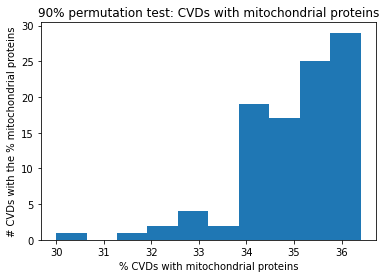

In [87]:
# note: turn into a function
all_sim_prop_cvds_with_mito_proteins = list()
simulations = 100
for sim in range(simulations):
    some_mito_prots = random.sample(list(human_mitochondrial_proteins), int(0.90*len(human_mitochondrial_proteins)))

    sim_cvds_to_mito_protein = dict()
    for cvd, mito_proteins in cvds_to_mito_protein.items():
        new_sim_prots = set(mito_proteins).intersection(set(some_mito_prots))
        if len(new_sim_prots) > 0:
            sim_cvds_to_mito_protein[cvd] = new_sim_prots
    sim_prop_cvds_with_mito_proteins = round(len(sim_cvds_to_mito_protein)/len(cvds_to_protein), 3)*100
    all_sim_prop_cvds_with_mito_proteins.append(sim_prop_cvds_with_mito_proteins)
    
plt.title('90% permutation test: CVDs with mitochondrial proteins')
plt.ylabel('# CVDs with the % mitochondrial proteins')
plt.xlabel('% CVDs with mitochondrial proteins')
plt.hist(all_sim_prop_cvds_with_mito_proteins);
print('min - max', min(all_sim_prop_cvds_with_mito_proteins),'-',max(all_sim_prop_cvds_with_mito_proteins))
print(np.mean(all_sim_prop_cvds_with_mito_proteins))

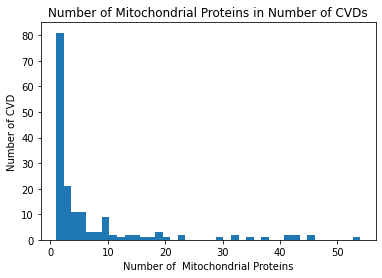

In [89]:
disease_name = 'CVD'
go_term = 'Mitochondrial'
cvd_to_proportion_mito_proteins, cvds_to_number_mito_proteins = display_display_disease_to_go_term_proteins(cvds_to_mito_protein, cvds_to_protein, disease_name, go_term)

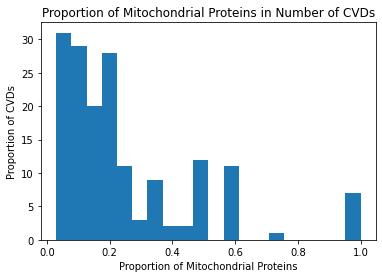

In [90]:
display_display_disease_to_go_term_proteins_proportion(cvd_to_proportion_mito_proteins, disease_name, go_term)

In [91]:
# CVDs with the highest proportion of mitochondrial proteins
cvds_most_mito_proteins_prop = sort_dict_by_values(cvd_to_proportion_mito_proteins)
cvd_names_most_mito_proteins_prop = [disease_id_to_name[cvd] for cvd in cvds_most_mito_proteins_prop]
cutoff = cvd_names_most_mito_proteins_prop.index('MELAS Syndrome') # top mitochondrial disease in the list
top_cvd_names_most_mito_proteins_prop = cvd_names_most_mito_proteins_prop[:cutoff]

# CVDs with the most number of mitochondrial proteins
cvds_most_mito_proteins = sort_dict_by_values(cvds_to_number_mito_proteins)
cvd_names_most_mito_proteins = [disease_id_to_name[cvd] for cvd in cvds_most_mito_proteins]
cutoff = cvd_names_most_mito_proteins.index('MELAS Syndrome')
top_cvd_names_most_mito_proteins = cvd_names_most_mito_proteins[:cutoff]

# Intersection of the two ^
top_cvd_names_with_mito_proteins = set(top_cvd_names_most_mito_proteins).intersection(set(top_cvd_names_most_mito_proteins_prop))
top_cvds_with_mito_proteins = [disease_name_to_id[cvd] for cvd in top_cvd_names_with_mito_proteins]

In [96]:
top_cvd_names_with_mito_proteins

{'Brain Stem Ischemia, Transient',
 'Carotid Circulation Transient Ischemic Attack',
 'Crescendo Transient Ischemic Attacks',
 'Posterior Circulation Transient Ischemic Attack',
 'Transient Cerebral Ischemia',
 'Transient Ischemic Attack, Anterior Circulation',
 'Transient Ischemic Attack, Vertebrobasilar Circulation'}

In [98]:
#top_cvd_names_with_mito_proteins
from gprofiler import GProfiler
for top_cvd in top_cvds_with_mito_proteins:
    break
    top_cvds_mito_proteins = cvds_to_mito_protein[top_cvd]
    gp = GProfiler(return_dataframe=True)
    df = gp.profile(organism='hsapiens', query=top_cvds_mito_proteins)
    #display(df.head(10))
# top mito proteins in stroke are related to apoptosis

In [878]:
# run, will take a while
cvds_enriched_for_mito = check_if_disease_to_proteins_is_enriched_for_go_term(cvd_to_protein, go_term = 'mitochondria')

In [880]:
len(cvds_enriched_for_mito)

0

##### Mitochondrial Proteins / Pathway Proteins

In [123]:
print('All Disease')
unique_proteins_in_drug_paths, proteins_in_drug_paths = get_all_pathway_proteins(drug_to_disease_to_proteins)
unique_mito_proteins_in_drug_paths, mito_proteins_in_drug_paths = get_pathway_mitochondrial_proteins(proteins_in_drug_paths, human_mitochondrial_proteins)
print(f'{round(len(mito_proteins_in_drug_paths)/len(proteins_in_drug_paths),3)*100}% mitchondrial proteins / proteins in drug pathways')
print(f'{round(len(unique_mito_proteins_in_drug_paths)/len(unique_proteins_in_drug_paths),3)*100}% unique mitochondrial proteins / unique proteins in drug pathways')

print('\nCVDs')
unique_proteins_in_drug_paths, proteins_in_drug_paths = get_all_pathway_proteins(drug_to_cvd_to_proteins)
unique_mito_proteins_in_drug_paths, mito_proteins_in_drug_paths = get_pathway_mitochondrial_proteins(proteins_in_drug_paths, human_mitochondrial_proteins)
print(f'{round(len(mito_proteins_in_drug_paths)/len(proteins_in_drug_paths),3)*100}% mitchondrial proteins / proteins in drug pathways')
print(f'{round(len(unique_mito_proteins_in_drug_paths)/len(unique_proteins_in_drug_paths),3)*100}% unique mitochondrial proteins / unique proteins in drug pathways')

All Disease
3.5000000000000004% mitchondrial proteins / proteins in drug pathways
8.4% unique mitochondrial proteins / unique proteins in drug pathways

CVDs
3.6999999999999997% mitchondrial proteins / proteins in drug pathways
7.7% unique mitochondrial proteins / unique proteins in drug pathways


In [ ]:
drug_to_cvd_to_proteins

In [151]:
# run, will take a while
#drug_cvd_path_enriched_for_go_term = get_drug_disease_enriched_for_go_term(drug_to_cvd_to_proteins, go_term = 'mitochondria')

In [391]:
#cvds_to_mito_protein

In [ ]:
# how many of mitochondrial proteins are in the pathways
# how many of the cvd-mitochondrial proteins are in the pathways

In [840]:
# check out overlapping pathways in the same diseases

In [889]:
cvd_to_drug_to_proteins = get_disease_to_drug_to_proteins(drug_to_cvd_to_proteins, drug_to_protein_dicts['target'], umls_cardiovascular_diseases)
cvd_to_targets = get_disease_to_targets(cvd_to_drug_to_proteins, drug_to_protein_dicts['target'])
cvd_to_pathway_protein_to_counts, cvd_to_disease_protein_to_counts, cvd_to_midpathway_protein_to_counts = get_disease_to_pathway_protein_to_counts(cvd_to_drug_to_proteins, cvd_to_targets, cvd_to_protein)

In [944]:
cvd_to_frequent_drug_pathway_protein = dict()
for cvd, disease_proteins_to_count in cvd_to_disease_protein_to_counts.items():
    midpathway_protein_to_count = cvd_to_midpathway_protein_to_counts_no_disease_protein[cvd]
    
    # sort disease proteins by count
    try: most_found_dis_protein = sort_dict_by_values(disease_proteins_to_count)[0]
    except: continue
    count_most_found_dis_protein = disease_proteins_to_count[most_found_dis_protein]

    # look at midpathway proteins
    for pathway_protein, count in midpathway_protein_to_count.items():
    # compare their count with the highest disease protein count
        if count >= count_most_found_dis_protein:
            cvd_to_frequent_drug_pathway_protein.setdefault(cvd, list()).append(pathway_protein)
            
json.dump(cvd_to_frequent_drug_pathway_protein, open('output/cvd_to_frequent_drug_pathway_protein.json','w'))

80


8.0125

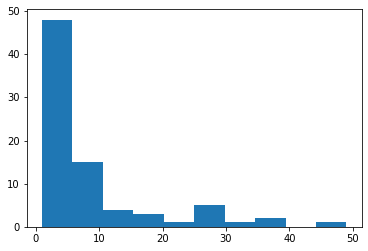

In [947]:
print(len(cvd_to_frequent_drug_pathway_protein))
freq_drug_pathway_proteins = [len(prots) for prots in list(cvd_to_frequent_drug_pathway_protein.values())]
plt.hist(freq_drug_pathway_proteins)
np.mean(freq_drug_pathway_proteins)

In [884]:

follow up to see why those proteins appear so often

7

In [1057]:
gene_to_anatomy_over = json.load(open(kgdr_path+'output/gene2anatomy/overexpressed_gene2anat.json'))
gene_to_anatomy_under = json.load(open(kgdr_path+'output/gene2anatomy/underexpressed_gene2anat.json'))
protein_to_anatomy_over = map_proteins_expressed_in_tissue(gene_to_anatomy_over, gene2protein)
protein_to_anatomy_under = map_proteins_expressed_in_tissue(gene_to_anatomy_under, gene2protein)

In [1036]:
# Note: make function
cardiovascular_anatomy = 'A07'
cardiovascular_anatomy_umls = get_umls_mesh_category(cardiovascular_anatomy, list(umls_to_mesh_id), umls_to_mesh_id, mesh_id_to_tree)
cardiovascular_anatomy_mesh = set()
for umls in cardiovascular_anatomy_umls:
    meshes = umls2mesh_id[umls]
    for mesh in meshes:
        cardiovascular_anatomy_mesh.add(mesh)
cardiovascular_anatomy_mesh = list(cardiovascular_anatomy_mesh)

In [1059]:
# note: make function, same as below
cardiovascular_underexpressed_proteins = list()
for protein, anatomy_ids in protein_to_anatomy_under.items():
    cardio_anatomy_ids = set(anatomy_ids).intersection(set(cardiovascular_anatomy_mesh))
    if len(cardio_anatomy_ids) > 0:
        cardiovascular_underexpressed_proteins.append(protein)

In [ ]:
cardiovascular_overexpressed_proteins = list()
for protein, anatomy_ids in protein_to_anatomy_over.items():
    cardio_anatomy_ids = set(anatomy_ids).intersection(set(cardiovascular_anatomy_mesh))
    if len(cardio_anatomy_ids) > 0:
        cardiovascular_overexpressed_proteins.append(protein)

In [1065]:
cardiovascular_diffexpressed_proteins = cardiovascular_overexpressed_proteins + cardiovascular_underexpressed_proteins

58


3.103448275862069

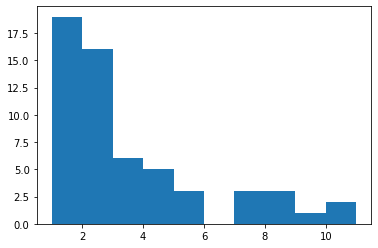

In [1063]:
cvd_to_frequent_drug_pathway_cardio_protein = dict()
for cvd, pathway_proteins in cvd_to_frequent_drug_pathway_protein.items():
    cardio_pathway_proteins = set(cardiovascular_overexpressed_proteins).intersection(set(pathway_proteins))
    if len(cardio_pathway_proteins) > 0:
        cvd_to_frequent_drug_pathway_cardio_protein[cvd] = cardio_pathway_proteins
        
print(len(cvd_to_frequent_drug_pathway_cardio_protein))
freq_drug_pathway_cardio_proteins = [len(prots) for prots in list(cvd_to_frequent_drug_pathway_cardio_protein.values())]
plt.hist(freq_drug_pathway_cardio_proteins)
np.mean(freq_drug_pathway_cardio_proteins)

38


2.5

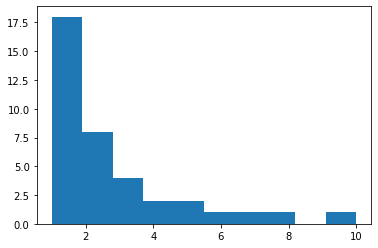

In [1064]:
cvd_to_frequent_drug_pathway_cardio_protein = dict()
for cvd, pathway_proteins in cvd_to_frequent_drug_pathway_protein.items():
    cardio_pathway_proteins = set(cardiovascular_underexpressed_proteins).intersection(set(pathway_proteins))
    if len(cardio_pathway_proteins) > 0:
        cvd_to_frequent_drug_pathway_cardio_protein[cvd] = cardio_pathway_proteins
        
print(len(cvd_to_frequent_drug_pathway_cardio_protein))
freq_drug_pathway_cardio_proteins = [len(prots) for prots in list(cvd_to_frequent_drug_pathway_cardio_protein.values())]
plt.hist(freq_drug_pathway_cardio_proteins)
np.mean(freq_drug_pathway_cardio_proteins)

63


4.285714285714286

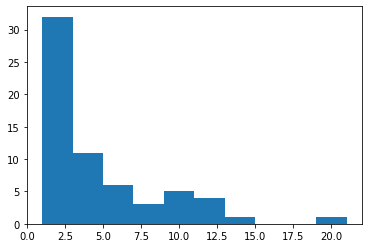

In [1066]:
cvd_to_frequent_drug_pathway_cardio_protein = dict()
for cvd, pathway_proteins in cvd_to_frequent_drug_pathway_protein.items():
    cardio_pathway_proteins = set(cardiovascular_diffexpressed_proteins).intersection(set(pathway_proteins))
    if len(cardio_pathway_proteins) > 0:
        cvd_to_frequent_drug_pathway_cardio_protein[cvd] = cardio_pathway_proteins
        
print(len(cvd_to_frequent_drug_pathway_cardio_protein))
freq_drug_pathway_cardio_proteins = [len(prots) for prots in list(cvd_to_frequent_drug_pathway_cardio_protein.values())]
plt.hist(freq_drug_pathway_cardio_proteins)
np.mean(freq_drug_pathway_cardio_proteins)